### Topic modeling with NMF and LDA

1. Load dataframe of Seattle listings and extract host descriptions with stopwords removed (but not lemmatized)
2. Create vector, run NMF, assign topic distributions to each listing, and pickle results using:
    * NMF
    * LDA
4. Visualize topics LDA topics with pyLDAvis
5. Complete LDA with gensim

Resources:
* [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py)
* [Practical Topic Finding for Short-Sentence Texts](http://nbviewer.jupyter.org/github/dolaameng/tutorials/blob/master/topic-finding-for-short-texts/topics_for_short_texts.ipynb)
* [Topic Modeling with Scikit Learn](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730#.gabw32h5e)
* [Improving the Interpretation of Topic Models](https://medium.com/towards-data-science/improving-the-interpretation-of-topic-models-87fd2ee3847d#.8j9ngyi91)
* [Care and Feeding of Topic Models: Problems, Diagnostics, and Improvements](https://mimno.infosci.cornell.edu/papers/2014_book_chapter_care_and_feeding.pdf)
* [Getting started with Latent Dirichlet Allocation in Python](http://chrisstrelioff.ws/sandbox/2014/11/13/getting_started_with_latent_dirichlet_allocation_in_python.html)
* [Exporting Python Data to GeoJSON](http://geoffboeing.com/2015/10/exporting-python-data-geojson/)

In [1]:
import pickle

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation

import json

from gensim import corpora, models, similarities, matutils

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#function to display top words within each topic
def display_topics(model, W, features, n):
    best_hosts = []
    for index, topic in enumerate(model.components_):
        print 'Topic %d:' % index
        print 'TOP %d WORDS:' % n
        for i in topic.argsort()[:-n - 1:-1]:
            print features[i]
        print 'REPRESENTATIVE HOST:'
        ind = np.argsort(W[:,index])[::-1][0]
        best_hosts.append(ind)
        print s_listings['abouts'].iloc[ind]
        print
    return best_hosts

In [3]:
#parameters for topic models
num_topics = 12
num_top_words = 10

#### Load Seattle listings dataframe and extract host descriptions (stopwords removed during preprocessing)

In [4]:
with open('data/s_listings.pkl', 'rb') as picklefile:
    s_listings = pickle.load(picklefile)

In [5]:
nonstop_abouts = s_listings['nonstop_abouts']
host_lemmas = s_listings['host_lemmas']

### NMF (sklearn)

#### Create TFIDF vector using host descriptions (stopwords removed)

In [6]:
nmf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 min_df=3,
                                 token_pattern="\\b[a-z][a-z]+\\b")

tfidf = nmf_vectorizer.fit_transform(host_lemmas)
nmf_features = nmf_vectorizer.get_feature_names()
len(nmf_features)

4262

In [7]:
#10 words with highest tfidf
top = nmf_vectorizer.idf_.argsort()[:10].tolist()
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in top]

[(u'make', 2.8323329856752215),
 (u'family', 2.9131523924169302),
 (u'food', 2.9720949280503803),
 (u'get', 3.0695502642010934),
 (u'hike', 3.0894316347549222),
 (u'experience', 3.1304209792881195),
 (u'look', 3.1388243900844985),
 (u'explore', 3.19523847936459),
 (u'friend', 3.1997127597595112),
 (u'music', 3.2087218297018771)]

In [8]:
#10 words with lowest tfidf
bottom = nmf_vectorizer.idf_.argsort()[::-1].tolist()[:10]
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in bottom]

[(u'abbey', 7.2205901700997392),
 (u'find cool', 7.2205901700997392),
 (u'menu', 7.2205901700997392),
 (u'college student', 7.2205901700997392),
 (u'college spend', 7.2205901700997392),
 (u'college graduate', 7.2205901700997392),
 (u'right heart', 7.2205901700997392),
 (u'right next', 7.2205901700997392),
 (u'rise', 7.2205901700997392),
 (u'mention', 7.2205901700997392)]

#### Extract topics using NMF on TFIDF vector of host descriptions
* Number of components set to number of topics
* init set to Nonnegative Double Singular Value Decomposition (nndsvd), which is better for sparse matrices
* solver set to cd (recommended in documentation)

In [9]:
nmf = NMF(n_components=num_topics,
          init='nndsvd',
          solver = 'cd',
          random_state=16)
nmf_doc_topic = nmf.fit_transform(tfidf)
nmf_doc_topic.shape

(2011, 12)

In [10]:
nmf_doc_topic_norm = nmf_doc_topic/np.sum(nmf_doc_topic, axis=1, keepdims=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [11]:
sum(nmf_doc_topic_norm[1])

0.99999999999999978

In [12]:
nmf_topic_word = nmf.components_
nmf_topic_word.shape

(12, 4262)

In [13]:
best_nmf_hosts = display_topics(nmf, nmf_doc_topic, nmf_features, num_top_words)

Topic 0:
TOP 10 WORDS:
make
experience
help
get
want
know
happy
feel
house
visit
REPRESENTATIVE HOST:
i am originally from california and moved to seattle in 2006. i love music, movies, reading, and trying new bars and restaurants, which makes seattle a great fit for me. i also like traveling and seeing new places, having time to really experience a place, walking around, people-watching, and trying local favorites. 

when traveling, i try to be economical while also making sure i have a full, rich experience. i think there are plenty of great places to stay, restaurants to try, and experiences to have that are special and don't have to cost a fortune. 

as a host, i want to help my guests have the best experience possible. if that consists of giving them suggestions or even helping them with transportation, i am happy to oblige. if they just want me to show them the space, give them the key, and nothing more, that is fine too. seattle is a great place, and everyone should be able to e

In [14]:
best_nmf_hosts

[435, 301, 1829, 581, 1913, 572, 1965, 1402, 23, 1672, 1742, 1743]

In [15]:
s_listings['abouts'].iloc[best_nmf_hosts[-1]]

u'software engineer exploring seattle'

In [120]:
nmf_topics = ['local guide', 'professional', 'excited traveler', \
           'pnw', 'outdoorsy', 'family & friends', 'educational transplants', \
          'capitol hill', 'real_estate', 'explorers', 'artsy', 'engineer']

In [17]:
#test_host = ['love to kayak, hike, climb, and be outdoors in pnw']
test_host = ['love to kayak, hike, climb, and be outdoors in pacific northwest']

In [119]:
len(nmf_topics)

12

In [18]:
test_host_vec = nmf_vectorizer.transform(test_host)

In [19]:
np.argmax(nmf.transform(test_host_vec)[0])

3

In [121]:
nmf_demo = [nmf, nmf_vectorizer, nmf_doc_topic, nmf_topics]
with open('data/nmf_demo.pkl', 'wb') as picklefile:
    pickle.dump(nmf_demo, picklefile)

#### A couple visualizations!

In [20]:
len(nmf_topic_word[0])

4262

In [ ]:
#plot importance of each word for each topic (1 plot per topic)
def plot_word_prob(topics, topic_word):
    f, ax= plt.subplots(len(topics), 1, figsize=(8, 24), sharex=True)
    x_min = -50
    x_max = len(topic_word[0]) + 50
    y_min = 0
    
    for i, k in enumerate(topics):
        y_max = round(max(topic_word[i])*1.1, 1)
        ax[i].stem(topic_word[i], linefmt='b-', markerfmt='bo', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("topic {}".format(k))

    plt.tight_layout()
    plt.show()

In [ ]:
round(max(nmf_topic_word.flatten())*1.1, 1)

In [ ]:
plot_word_prob(nmf_topics, nmf_topic_word)

In [ ]:
#plot importance of all topics for document most representative of each topic (1 plot per topic)
def plot_doc_prob(best_hosts, doc_topic):
    f, ax= plt.subplots(len(best_hosts), 1, figsize=(8, 24), sharex=True)
    x_min = -1
    x_max = len(best_hosts)
    y_min = 0
    y_max = max(1, round(max(doc_topic.flatten())*1.1, 1))
    
    for i, k in enumerate(best_hosts):
        ax[i].stem(doc_topic[k], linefmt='r-', markerfmt='ro', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("Document {}".format(k))

    plt.tight_layout()
    plt.show()

In [ ]:
plot_doc_prob(best_nmf_hosts, nmf_doc_topic)

#### Visualizations for presenting

In [53]:
import seaborn as sns
sns.set_style('white')

In [ ]:
viz_topics = {0: 1, 1: 4}

In [94]:
def plot_for_viz(index, topic, topic_word, features):
    print features[topic_word[index].argmax()[:3]]
    
    f, ax= plt.subplots(1, 1, figsize=(8, 2), sharex=True)
    x_min = -10
    x_max = len(topic_word[0])+10
    y_min = 0
    y_max = round(max(topic_word[index])*1.1, 1)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    markerline, stemlines, baseline = ax.stem(topic_word[index]) #, linefmt='k-', markerfmt='ko', basefmt='k-')
    plt.setp(markerline, 'color', '#595959')
    plt.setp(stemlines, 'color', '#595959')
    plt.setp(baseline, 'color', '#595959')
    
    plt.tight_layout()
    plt.show()

hike


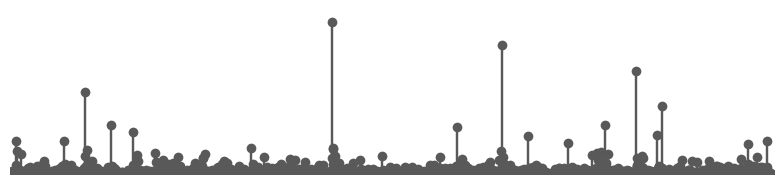

In [96]:
plot_for_viz(4, 'outdoorsy', nmf_topic_word, nmf_features)

professional


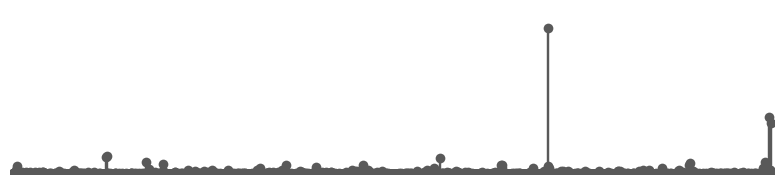

In [97]:
plot_for_viz(1, 'professional', nmf_topic_word, nmf_features)

#### Assign topic distribution to each listing

In [98]:
nmf_topics = pd.DataFrame(nmf_doc_topic, columns=nmf_topics)

In [99]:
nmf_topics = nmf_topics.merge(s_listings[['abouts', 'latitude', 'longitude']], left_index=True, right_index=True)

In [100]:
#create geojson of topic distributions for visualization on web map
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

In [101]:
columns = nmf_topics.columns.tolist()
columns += ['abouts']
geojson = df_to_geojson(nmf_topics, columns)

In [102]:
output_filename='viz/nmf_topics.json'
with open(output_filename, 'wb') as output_file:
    json.dump(geojson, output_file, indent=2)

In [103]:
nmf_topics.to_csv('viz/nmf_topics.csv', encoding='utf-8')

#### Pickle nmf topics dataframe

In [104]:
with open('data/nmf_topics.pkl', 'wb') as picklefile:
    pickle.dump(nmf_topics, picklefile)

### LDA (sklearn)

#### Create term frequency vector using host descriptions (stopwords removed)

In [105]:
# Create a CountVectorizer for parsing/counting words
lda_vectorizer = CountVectorizer(ngram_range=(1,2),
                                 min_df=3,
                                 token_pattern="\\b[a-z][a-z]+\\b")
counts = lda_vectorizer.fit_transform(host_lemmas)
lda_features = lda_vectorizer.get_feature_names()
len(lda_features)

4262

#### Extract topics using LDA on counts vector of host descriptions
* Number of components set to number of topics
* Learning method set to online for better performance

In [106]:
lda = LatentDirichletAllocation(n_topics=num_topics,
                                learning_method='online',
                                random_state=16)
lda_doc_topic = lda.fit_transform(counts)

In [107]:
lda_topic_word = lda.components_

In [108]:
best_lda_hosts = display_topics(lda, lda_doc_topic, lda_features, num_top_words)

Topic 0:
TOP 10 WORDS:
make
experience
house
get
family
look
visit
local
well
explore
REPRESENTATIVE HOST:
i am originally from naples, italy, but i also lived for a few years in london, uk, before moving to seattle six years ago. i try to go back to europe at least once a year. my roots there are still really strong, even though i find myself more and more falling in love with this crazy unique place that is the us.

i love to travel and visit different places. in the last few years i visited mexico (quite a few times), bali, hong kong, dubai, oman, doha, vietnam, and i can't wait to start planning my next big trip: scandinavia!

being a traveler myself, i believe i understand what a person is looking for when moving from point a to point b: comfort, good vibes, good locations, good transport options, and i believe that our space offers that in abundance. of course, no place is perfect for everyone. in italian we have a saying: la vita è bella perché è varia (life is beautiful because

In [109]:
lda_topics = ['local guide', 'retired w/hobbies', 'hippies', 'queen anne', \
             'topic 4', 'capitol hill', 'topic 6', 'from LA', 'laid back', \
              'outdoorsy', 'professional', 'real estate']

In [110]:
lda_topic_word_norm = lda_topic_word/np.sum(lda_topic_word, axis=1, keepdims=True)

In [111]:
round(max(lda_topic_word.flatten())*1.1, -1)

350.0

In [ ]:
plot_word_prob(lda_topics, lda_topic_word)

In [ ]:
plot_doc_prob(best_lda_hosts, lda_doc_topic)

In [ ]:
test_host = ['east coast']

In [ ]:
test_host_vec = lda_vectorizer.transform(test_host)

In [ ]:
np.argmax(lda.transform(test_host_vec)[0])

In [ ]:
test_host_vec

#### Visualizations for presenting

hike


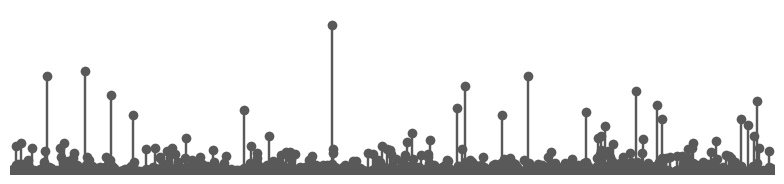

In [112]:
plot_for_viz(9, 'outdoorsy', lda_topic_word, lda_features)

young


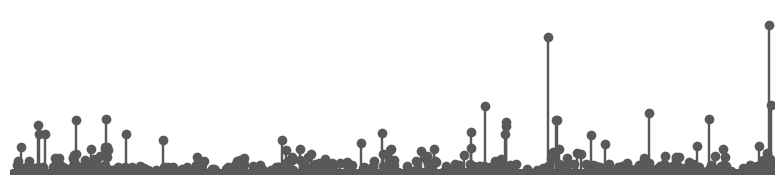

In [113]:
plot_for_viz(10, 'professional', lda_topic_word, lda_features)

#### Assign topic distribution to each listing

In [ ]:
lda_topics = pd.DataFrame(lda_doc_topic, columns=lda_topics)

In [ ]:
lda_topics.head()

#### Pickle lda topics dataframe

In [ ]:
with open('data/lda_topics.pkl', 'wb') as picklefile:
    pickle.dump(lda_topics, picklefile)

### gensim LDA

In [ ]:
# Create the term-document matrix
# Transpose it so the terms are the rows
gensim_counts = tfidf.transpose()

In [ ]:
gensim_counts.shape

##### Convert to gensim
We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [ ]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(gensim_counts)

In [ ]:
id2word = dict((v, k) for k, v in lda_vectorizer.vocabulary_.items())

At this point we can simply plow ahead in creating an LDA model.  It requires our corpus of word counts, mapping of row ids to words, and the number of topics.

In [ ]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10)

Let's take a look at what happened.  Here are the 5 most important words for each of the topics we found:

In [ ]:
lda.print_topics()

#### Topic Space
If we want to map our documents to the topic space we need to actually use the LdaModel transformer that we created above, like so:

In [ ]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [ ]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [ ]:
# Check out the document vectors in the topic space for the first 5 documents
lda_docs[245]

In [ ]:
s_listings['abouts'].iloc[245]

### pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
tf_vectorizer = CountVectorizer(ngram_range=(1,2),
                                 min_df=5,
                                 token_pattern="\\b[a-z][a-z]+\\b")
dtm_tf = tf_vectorizer.fit_transform(host_lemmas)
print dtm_tf.shape

In [ ]:
lda_tf = LatentDirichletAllocation(n_topics=12, random_state=0)
lda_tf.fit(dtm_tf)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)